<a href="https://colab.research.google.com/github/Ekawaka/MACHINE-LEARNING-1/blob/main/medical_insurance_premuim_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduction**

Importing necessary libraries

In [2]:
# Importing general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Class Imbalance
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

# Machine Learning Model Evaluation Methods
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [3]:
data = pd.read_csv('/content/medical_insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [7]:
#get_dummies to strings, sex, smoker and region and concat with original data
data_dummied = pd.concat([data, pd.get_dummies(data[['sex', 'smoker', 'region']])], axis=1)

In [8]:
#drop the columns that i get_dummied
data_dummied.drop(columns=['sex', 'smoker', 'region'], inplace=True)

In [9]:
data_dummied.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,True,False,False,False,True,False
2,28,33.000,3,4449.46200,False,True,True,False,False,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False,True,False,False


2. **EDA**

In [10]:
# To understand my data
data.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


**Insights into the exploration**

* The key variable of interest is 'charges', which is a continuous float value, showing the insurance premium associated with each individual.
* A broad age range between 18 to 22.5 years, predominantly male.
* Most individual have fewer than three children, with a BMI range(29.26 to 31.16) indicating overweight to moderate obesity.
*  There are four regions (northeast, northwest, southeast, and southwest), with a higher prevalence of smokers in the southeast.  
*  This analysis aims to explore how age, sex, BMI, children, smoking status, and region influence medical insurance premiums.
*   No missing values.









In [19]:
# data.hist(figsize=(12, 10), bins=30, edgecolor="blue")
# plt.subplots_adjust(hspace=0.7, wspace=0.4)

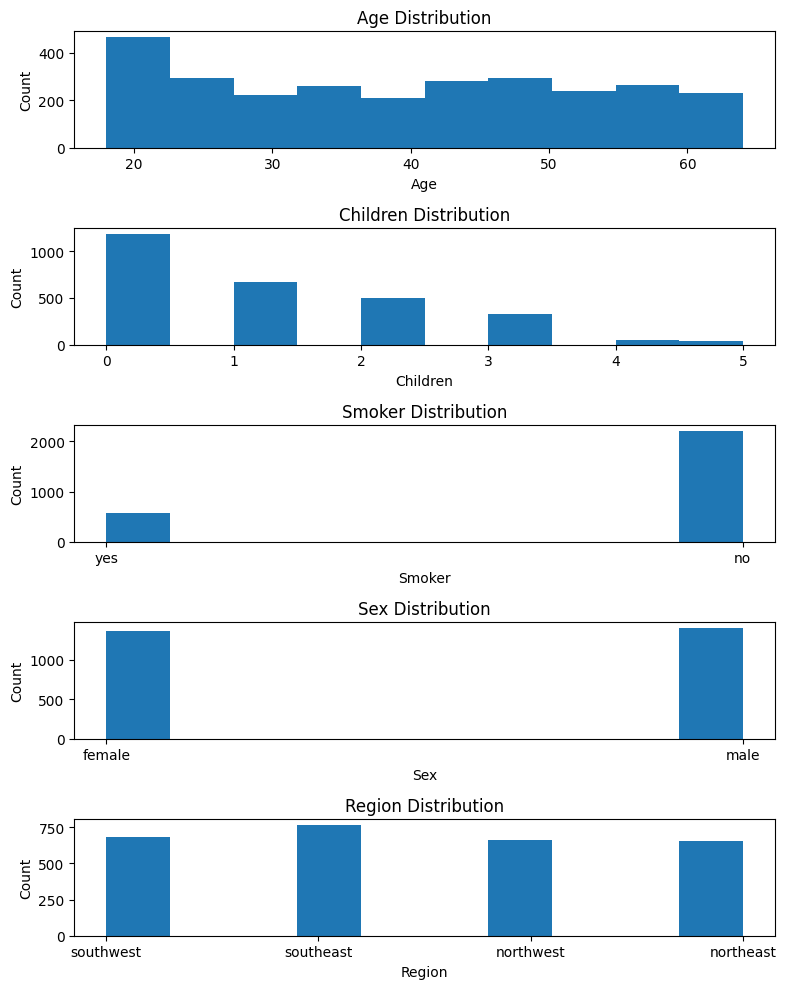

In [22]:
#Subplots with hist
fig, axs = plt.subplots(5, figsize=(8,10))

axs[0].hist(data['age'], bins=10)
axs[0].set_title('Age Distribution')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')

axs[1].hist(data['children'], bins=10)
axs[1].set_title('Children Distribution')
axs[1].set_xlabel('Children')
axs[1].set_ylabel('Count')

axs[2].hist(data['smoker'], bins=10)
axs[2].set_title('Smoker Distribution')
axs[2].set_xlabel('Smoker')
axs[2].set_ylabel('Count')

axs[3].hist(data['sex'], bins=10)
axs[3].set_title('Sex Distribution')
axs[3].set_xlabel('Sex')
axs[3].set_ylabel('Count')

axs[4].hist(data['region'], bins=10)
axs[4].set_title('Region Distribution')
axs[4].set_xlabel('Region')
axs[4].set_ylabel('Count')

plt.tight_layout()

plt.show()

3. **What are the primary factors influencing medical insurance premiums?**

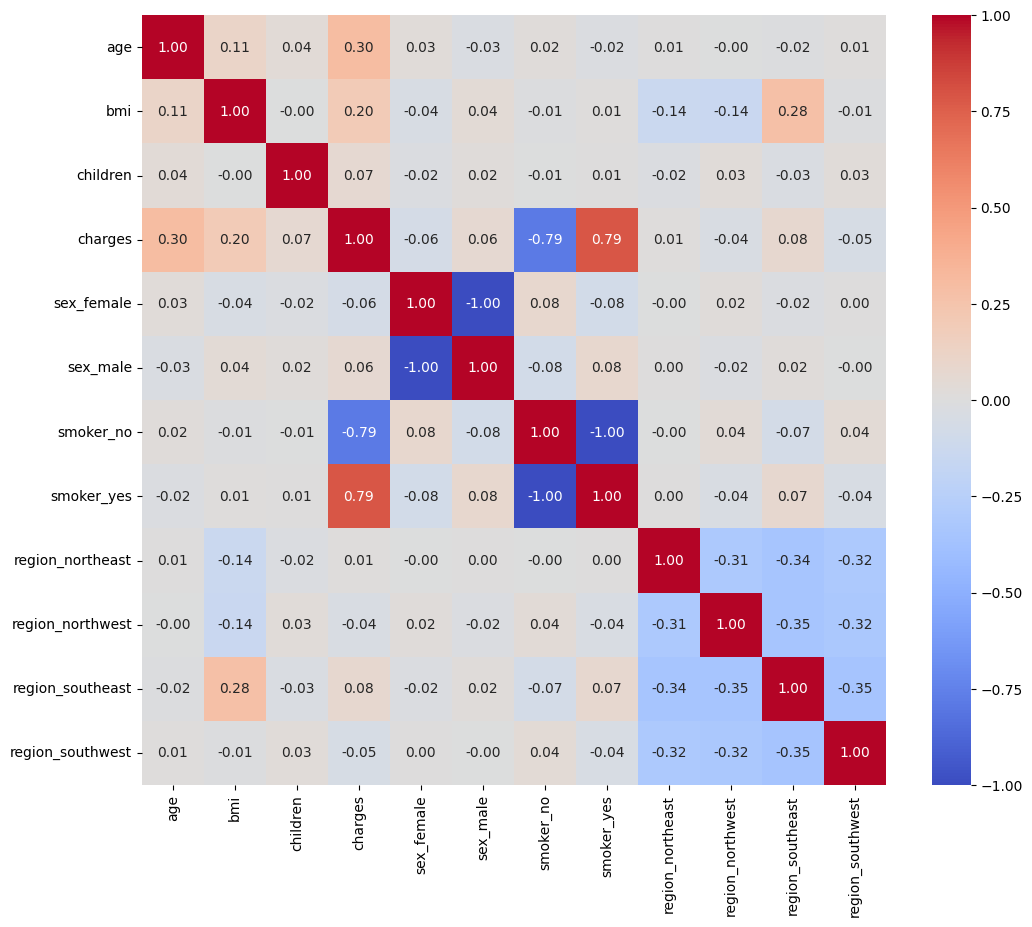

In [12]:
#Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data_dummied.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

**Insights from the exploration.**

The primary factor to medical insurance premiums are smokers, with 79% correlation, followed by age with 30% correlation and bmi with 20%.

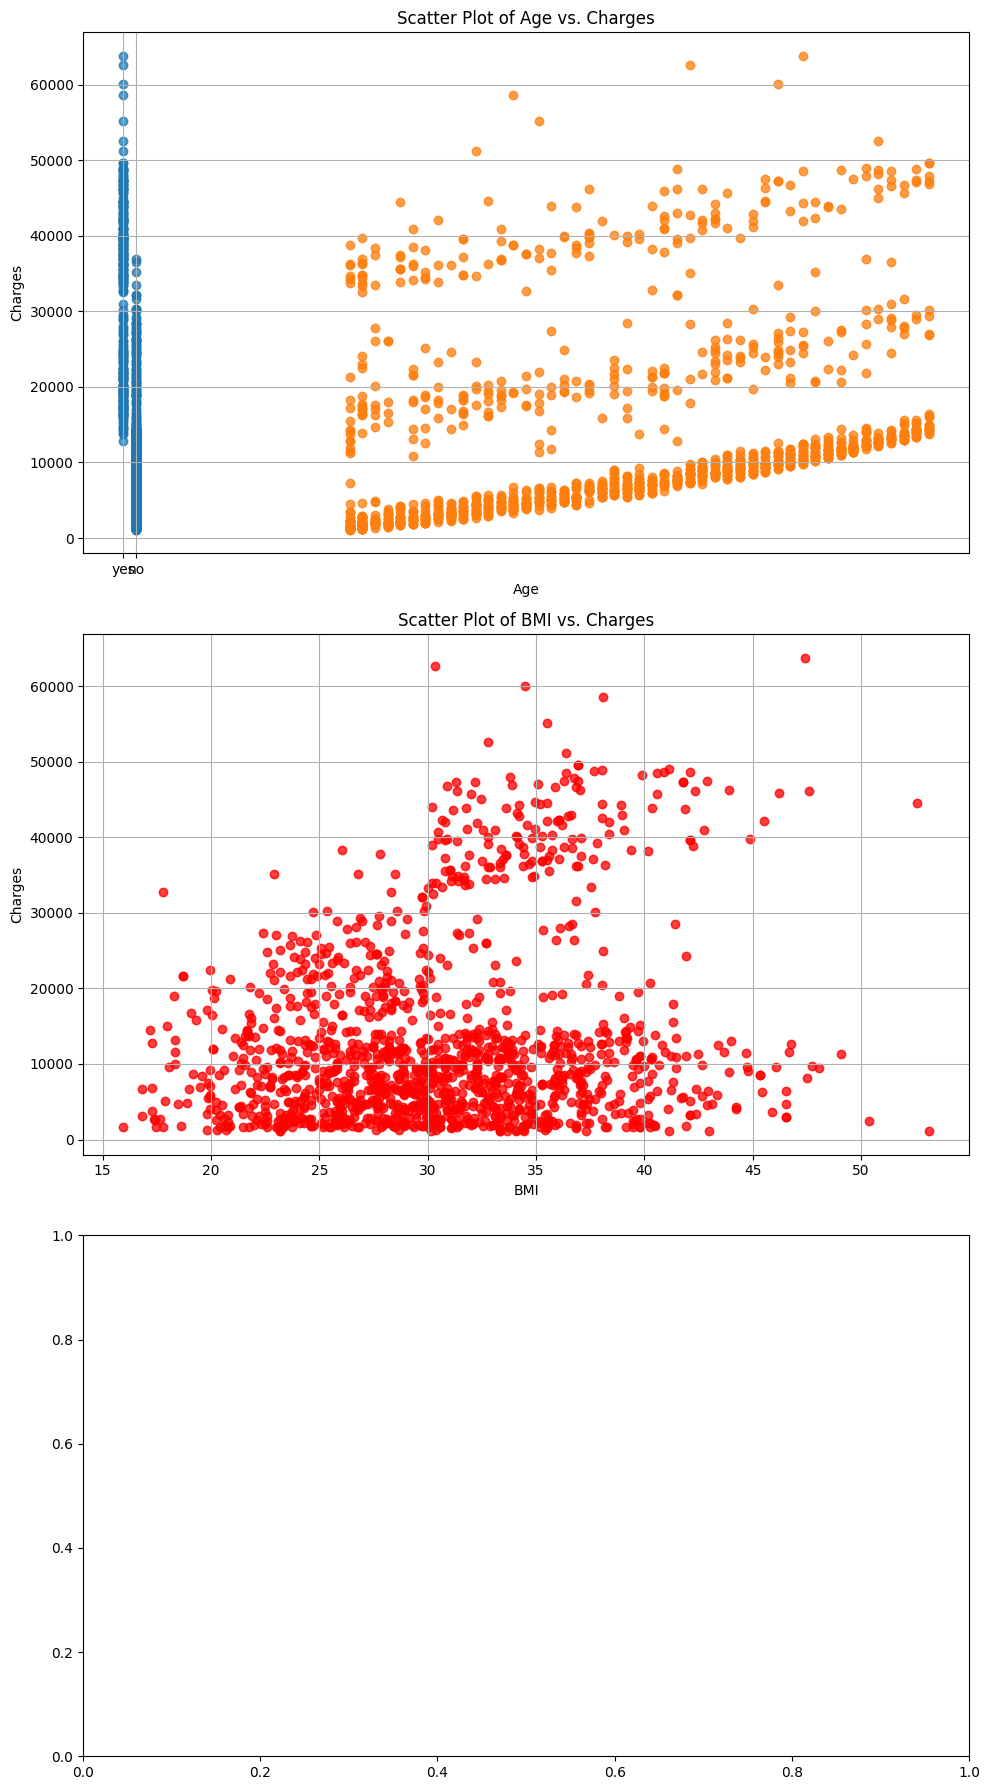

In [24]:
# Scatterplots analysis.
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
# Scatter Plot of smoker vs. Charges
axs[0].scatter(data['smoker'], data['charges'], alpha=0.5)
axs[0].set_title('Scatter Plot of smoker vs. Charges')
axs[0].set_xlabel('smoker')
axs[0].set_ylabel('Charges')
axs[0].grid(True)

# Scatter Plot of Age vs. Charges
axs[0].scatter(data['age'], data['charges'], alpha=0.5)
axs[0].set_title('Scatter Plot of Age vs. Charges')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Charges')
axs[0].grid(True)

# Scatter Plot of BMI vs. Charges
axs[1].scatter(data['bmi'], data['charges'], alpha=0.5, color='r')
axs[1].set_title('Scatter Plot of BMI vs. Charges')
axs[1].set_xlabel('BMI')
axs[1].set_ylabel('Charges')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

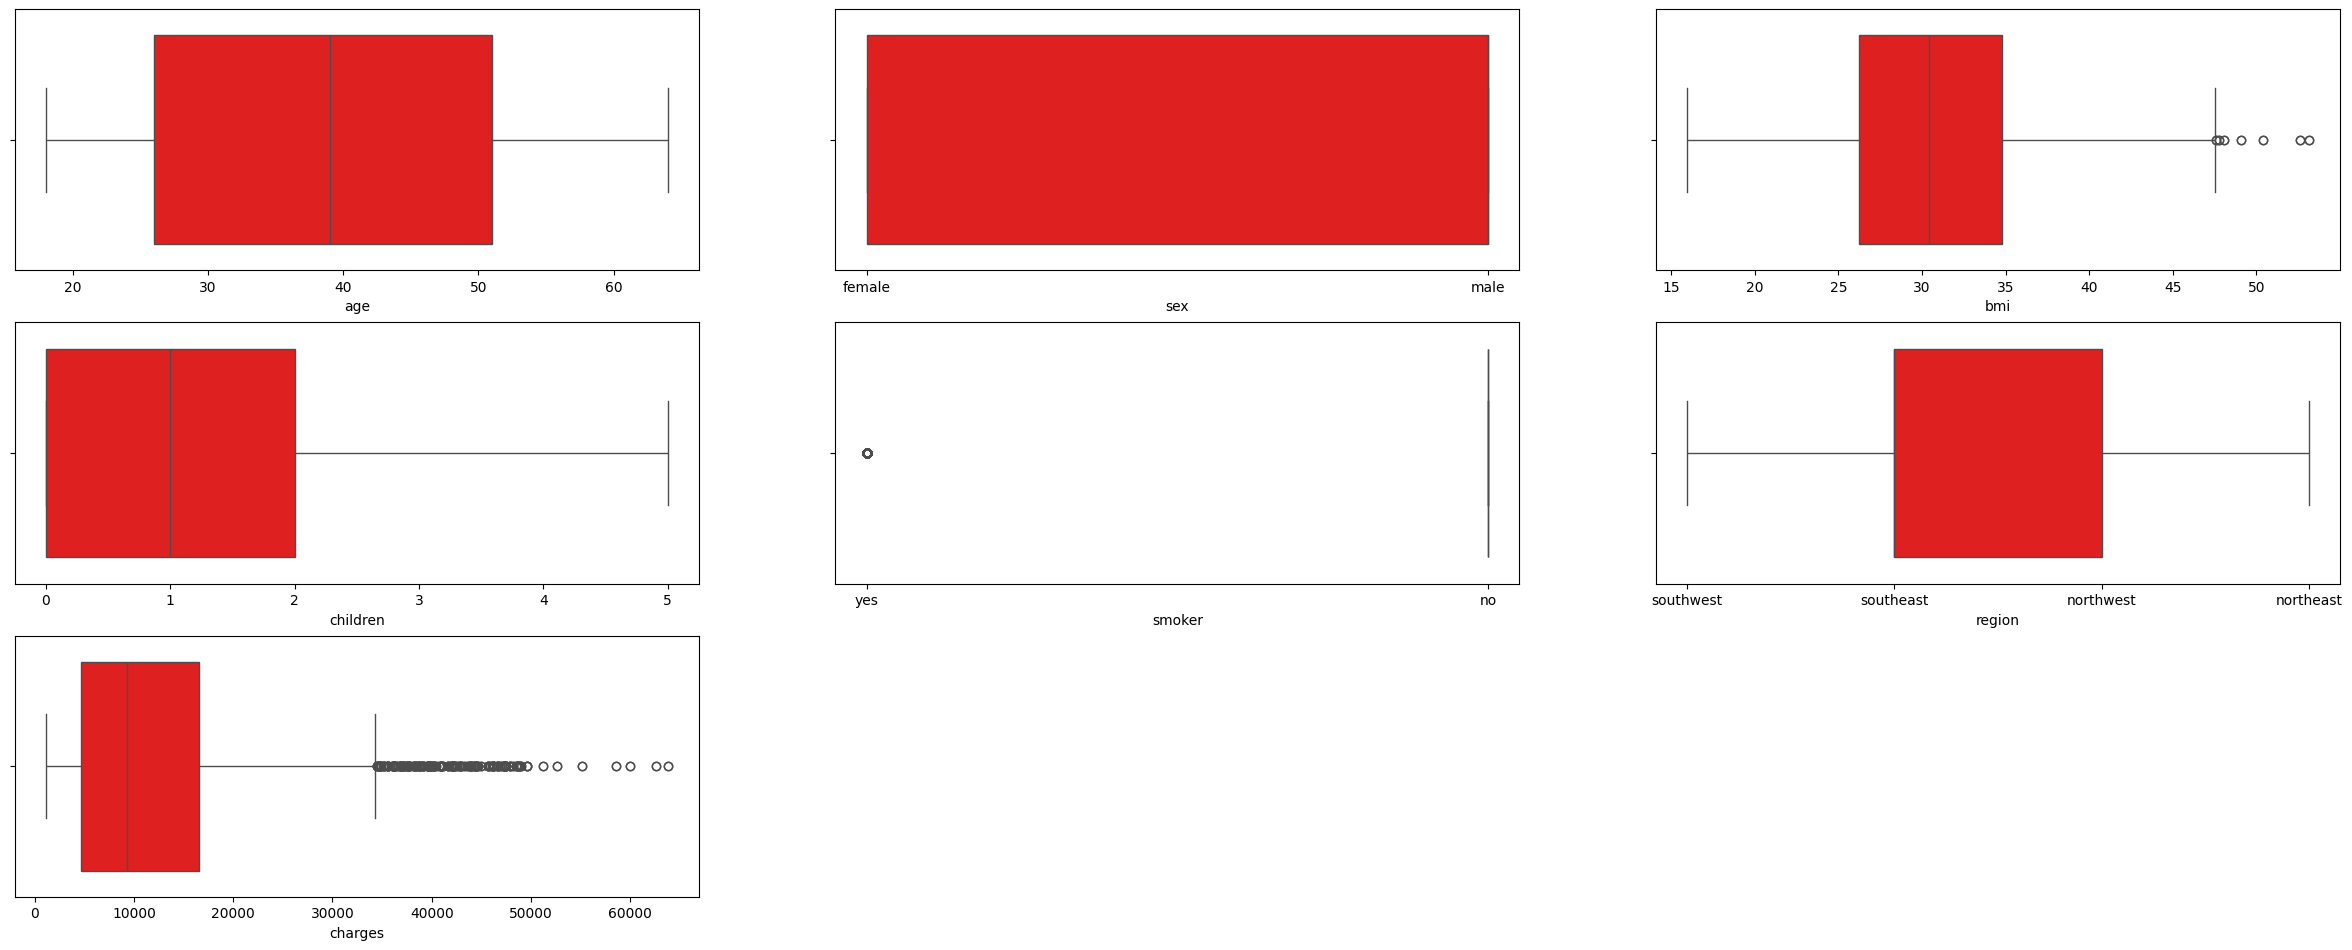

In [33]:
## Check for outliers
# Unitvariate analysis of all the numerical variables - we are trying to see if there are outliers.
fig = plt.figure(figsize=(30,40))
for i,j in zip(data.columns,range(len(data.columns))):
    if i!='label':
        ax = fig.add_subplot(10,3, j+1)
        sns.boxplot(data=data,x=data[i],orient='v',color="red")